<a href="https://colab.research.google.com/github/Sahar-DataScience/Self-supervised-segmentation-on-partially-labeled-data/blob/main/image_processing_on_sentinel_imgs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Collecting remote sensing images taken by Sentinel-2 : the data is prepared for tracking harmful algal bloom severity in some lakes across America (USA)**

DATA from Tick Tick Bloom: Harmful Algal Bloom Detection Challenge on driven data [link](https://https://www.drivendata.org/competitions/143/tick-tick-bloom/)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
import os
import requests
from tqdm.auto import tqdm

In [3]:
os.chdir('/content/drive/MyDrive/DrivenData')

In [4]:
# Function to download data
def data_downloader(url, token, file_name):
    # Get the competition data
    competition_data = requests.post(url = data_url, data= token, stream=True)

    # Progress bar monitor download
    pbar = tqdm(desc=file_name, total=int(competition_data.headers.get('content-length', 0)), unit='B', unit_scale=True, unit_divisor=512)
    # Create and Write the data to colab drive in chunks
    handle = open(file_name, "wb")
    for chunk in competition_data.iter_content(chunk_size=512): # Download the data in chunks
        if chunk: # filter out keep-alive new chunks
                handle.write(chunk)
        pbar.update(len(chunk))
    handle.close()
    pbar.close()

## intalling dependencies

In [5]:
!pip install pystac
!pip install pystac_client
!pip install planetary_computer
!pip install nb_black
!pip install odc-stac
!pip install geopandas
!pip install rioxarray
!pip install loguru
!pip install opencv-python
!pip install geopy
!pip install path
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.9/182.9 kB 3.6 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.8/149.8 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 2.1 MB/s eta 0:00:00


In [6]:
!pip install rasterio

#importing dependencies

In [5]:
#%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [20]:
import cv2
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
#import odc.stac
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

%matplotlib inline

# **metadata.csv**

In [7]:
metadata = pd.read_csv("metadata.csv")
metadata.head()

,uid,latitude,longitude,date,split
0,aabm,39.080319,-86.430867,2018-05-14,train
1,aabn,36.559700,-121.510000,2016-08-31,test
2,aacd,35.875083,-78.878434,2020-11-19,train
3,aaee,35.487000,-79.062133,2016-08-24,train
4,aaff,38.049471,-99.827001,2019-07-23,train


In [8]:
metadata.split.value_counts(dropna=False)

split
train    17060
test      6510
Name: count, dtype: int64

In [9]:
metadata.loc[0]

uid                aabm
latitude      39.080319
longitude    -86.430867
date         2018-05-14
split             train
Name: 0, dtype: object

## Location

Let's take a look at the distribution of samples by location.

In [10]:
import geopandas as gpd
from shapely.geometry import Point

# load the default geopandas base map file to plot points on
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

<ipython-input-10-6f3457bd1dc6>:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


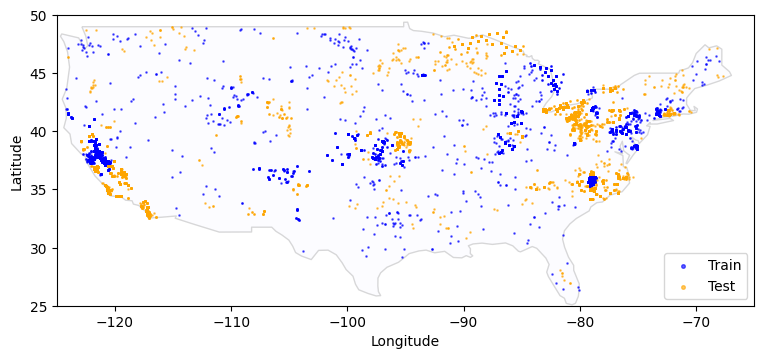

In [14]:
fig, ax = plt.subplots(figsize=(9, 4))

# map the training data
base = world[world.name == "United States of America"].plot(
    edgecolor="gray", color="ghostwhite", figsize=(9, 4), alpha=0.3, ax=ax
)
train_meta = metadata[metadata["split"] == "train"]
geometry = [Point(xy) for xy in zip(train_meta["longitude"], train_meta["latitude"])]
gdf = gpd.GeoDataFrame(train_meta, geometry=geometry)
gdf.plot(ax=base, marker=".", markersize=3, color="blue", label="Train", alpha=0.6)

# map the test data
test_meta = metadata[metadata["split"] == "test"]
geometry = [Point(xy) for xy in zip(test_meta["longitude"], test_meta["latitude"])]
gdf = gpd.GeoDataFrame(test_meta, geometry=geometry)
gdf.plot(ax=base, marker=".", markersize=3, color="orange", label="Test", alpha=0.6)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.xlim([-125, -65])
plt.ylim([25, 50])
plt.legend(loc=4, markerscale=3)

We can see that the sampling points are distributed all throughout the continental United States.

## Date

What date range are the samples from?

In [11]:
# convert date to pd.datetime
metadata.date = pd.to_datetime(metadata.date)

# what is the date range?
metadata.groupby("split").agg(min_date=("date", min), max_date=("date", max))

,min_date,max_date
split,,
test,2013-01-08,2021-12-29
train,2013-01-04,2021-12-14


Text(0.5, 1.0, 'Distribution of years in the data')

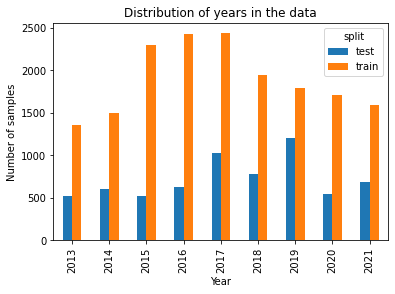

In [ ]:
# what years are in the data?
pd.crosstab(metadata.date.dt.year, metadata.split).plot(kind="bar")
plt.ylabel("Number of samples")
plt.xlabel("Year")
plt.title("Distribution of years in the data")

In [12]:
# what seasons are the data points from?
metadata["season"] = (
    metadata.date.dt.month.replace([12, 1, 2], "winter")
    .replace([3, 4, 5], "spring")
    .replace([6, 7, 8], "summer")
    .replace([9, 10, 11], "fall")
)
metadata.season.value_counts()

season
summer    10813
spring     5045
fall       4758
winter     2954
Name: count, dtype: int64

Most of the data is from summer. Harmful algal blooms are more likely to be dangerous during the summer because more individuals are taking advantage of water bodies like lakes for recreation.

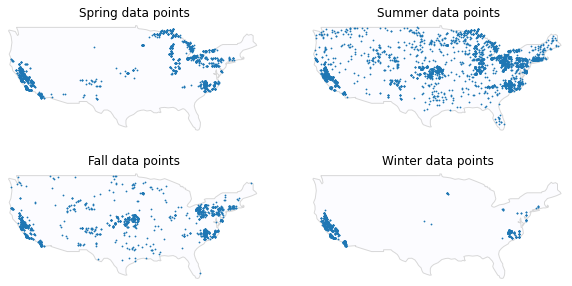

In [ ]:
# where is data from for each season?
fig, axes = plt.subplots(2, 2, figsize=(10, 5))

for season, ax in zip(metadata.season.unique(), axes.flatten()):
    base = world[world.name == "United States of America"].plot(
        edgecolor="gray", color="ghostwhite", alpha=0.3, ax=ax
    )

    sub = metadata[metadata.season == season]
    geometry = [Point(xy) for xy in zip(sub["longitude"], sub["latitude"])]
    gdf = gpd.GeoDataFrame(sub, geometry=geometry)
    gdf.plot(ax=base, marker=".", markersize=2.5)
    ax.set_xlim([-125, -66])
    ax.set_ylim([25, 50])
    ax.set_title(f"{season.capitalize()} data points")
    ax.axis("off")

## **train_labels.csv**

Let's look at the labels for the training data.


In [13]:
train_labels = pd.read_csv("train_labels.csv")
train_labels.head(15)

,uid,region,severity,density
0,aabm,midwest,1,585.0
1,aacd,south,1,290.0
2,aaee,south,1,1614.0
3,aaff,midwest,3,111825.0
4,aafl,midwest,4,2017313.0
5,aafp,south,1,1594.0
6,aagm,south,1,3873.0
7,aahy,south,1,6100.0
8,aaia,south,1,16943.0
9,aaie,south,2,22822.0


In [16]:
train_labels.shape

(17060, 4)

## **train_labels severity**


In [14]:
train_labels_and_metadata = train_labels.merge(
    metadata, how="left", left_on="uid", right_on="uid", validate="1:1"
)

Text(0.5, 1.0, 'Train labels severity level counts')

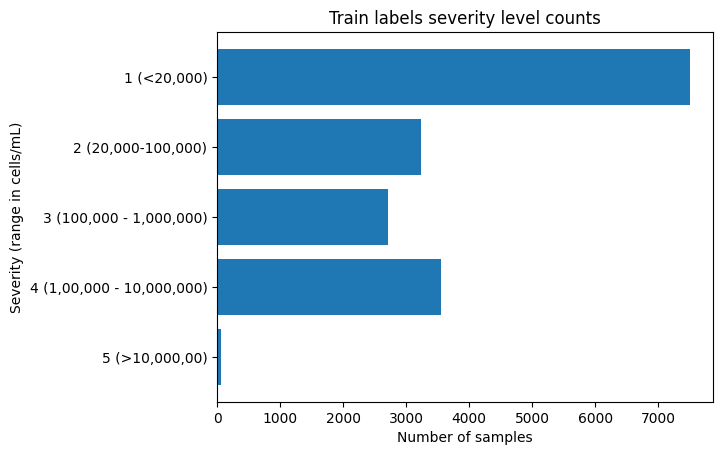

In [15]:
severity_counts = (
    train_labels.replace(
        {
            "severity": {
                1: "1 (<20,000)",
                2: "2 (20,000-100,000)",
                3: "3 (100,000 - 1,000,000)",
                4: "4 (1,00,000 - 10,000,000)",
                5: "5 (>10,000,00)",
            }
        }
    )
    .severity.value_counts()
    .sort_index(ascending=False)
)
plt.barh(severity_counts.index, severity_counts.values)
plt.xlabel("Number of samples")
plt.ylabel("Severity (range in cells/mL)")
plt.title("Train labels severity level counts")

In [16]:
train_labels.density.describe()

count    1.706000e+04
mean     1.074537e+06
std      6.836693e+06
min      0.000000e+00
25%      4.066000e+03
50%      3.270975e+04
75%      4.849192e+05
max      8.046675e+08
Name: density, dtype: float64

There are also some rows where the density of cyanobacteria is 0.

In [ ]:
(train_labels.density == 0).sum()

91

# **Process feature data**

**we can access all feature data through
external, publicly available APIs**

Relevant imagery can be identified using the location and date of each sample, listed in metadata.csv

**The general steps we'll use to pull satellite data are:**

1. Establish a connection to the Planetary Computer's STAC API using the planetary_computer and pystac_client Python packages.

2. Query the STAC API for scenes that capture our in situ labels. For each sample, we'll search for imagery that includes the sample's location (latitude and longitude) around the date the sample was taken.  We'll use only Sentinel-2 L2A data for better quality of images.

3. Select one image for each sample. We'll use Sentinel-2 data wherever it is available, because it is higher resolution. We'll have to use Landsat for data before roughly 2016, because Sentinel-2 was not available yet.

4. **Convert the image to a 1-dimensional list of features that can be input into our tree model**

In [17]:
# Establish a connection to the STAC API
import planetary_computer as pc
from pystac_client import Client

catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1", modifier=pc.sign_inplace
)

## **WALK THROUGH PULLING FEATURE DATA FOR ONE SAMPLE**

Query the STAC API

## Chose the img with high bloom severity

 high severity = 3 or 4

In [114]:
import random
bloom_tr = train_labels.loc[train_labels["severity"].isin([3,4]),:]
#example_row = metadata[metadata.uid == "garm"].iloc[0] #yvab #aaqq
example_row = metadata[metadata.uid == random.choice(list(bloom_tr.uid))].iloc[0]
example_row

uid                         rvsx
latitude                 38.3677
longitude               -121.521
date         2016-07-13 00:00:00
split                      train
season                    summer
Name: 16201, dtype: object

In [116]:
example_row.latitude

37.055797

We can search (38.3677, -121.521) in Google maps to see example where this sample is from.
[link](https://www.google.com/maps/place/38%C2%B022'03.7%22N+121%C2%B031'15.6%22W/@38.3433724,-121.5572088,11412m/data=!3m1!1e3!4m4!3m3!8m2!3d38.3677!4d-121.521?entry=ttu)

In [117]:
import geopy.distance as distance

In [118]:
# get our bounding box to search latitude and longitude coordinates
def get_bounding_box(latitude, longitude, meter_buffer):
    """
    Given a latitude, longitude, and buffer in meters, returns a bounding
    box around the point with the buffer on the left, right, top, and bottom.

    Returns a list of [minx, miny, maxx, maxy]
    """
    distance_search = distance.distance(meters=meter_buffer)

    # calculate the lat/long bounds based on ground distance
    # bearings are cardinal directions to move (south, west, north, and east)
    min_lat = distance_search.destination((latitude, longitude), bearing=180)[0]
    min_long = distance_search.destination((latitude, longitude), bearing=270)[1]
    max_lat = distance_search.destination((latitude, longitude), bearing=0)[0]
    max_long = distance_search.destination((latitude, longitude), bearing=90)[1]

    return [min_long, min_lat, max_long, max_lat]
bbox = get_bounding_box(example_row.latitude, example_row.longitude, meter_buffer=50000)
bbox

[-121.68827255746075,
 36.605242923454405,
 -120.56401544253924,
 37.50631677836425]

In [119]:
# get our date range to search, and format correctly for query
def get_date_range(date, time_buffer_days=15):
    """Get a date range to search for in the planetary computer based
    on a sample's date. The time range will include the sample date
    and time_buffer_days days prior

    Returns a string"""
    #datetime_format = "%Y-%m-%dT"
    datetime_format = "%Y-%m-%dT%H:%M:%SZ"
    range_start = pd.to_datetime(date) - timedelta(days=time_buffer_days)
    date_range = f"{range_start.strftime(datetime_format)}/{pd.to_datetime(date).strftime(datetime_format)}"

    return date_range


date_range = get_date_range(example_row.date)
data_list = date_range.split('/')
data_list

['2016-06-28T00:00:00Z', '2016-07-13T00:00:00Z']

debug: change date time format to "%Y-%m-%dT%H:%M:%SZ"

In [120]:
# search the planetary computer sentinel-l2a and landsat level-2 collections
search = catalog.search(
    collections=["sentinel-2-l2a"], bbox=bbox, datetime=data_list
    )

# see how many items were returned
items = [item for item in search.get_all_items()]
len(items)

/usr/local/lib/python3.10/dist-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


4

### Select one image
The planetary computer returned 4 different items! Let's look at some of the details of the items that were found to match our label.

Remember that our example measurement was taken during period from **2016-06-28** till **2016-07-13**  at coordinates **(38.3677, -121.521)**. Because we used a bounding box around the sample to search, the Planetary Computer returned all items that contain any part of that bounding box. This means we still have to double check whether each item actually contains our sample point.

In [121]:
import statistics
# get details of all of the items returned
item_details = pd.DataFrame(
    [
        {
            "datetime": item.datetime.strftime("%Y-%m-%d"),
            #"datetime": item.datetime.strftime("%Y-%m-%dT%H:%M:%SZ")
            "platform": item.properties["platform"],
            "min_long": item.bbox[0],
            "max_long": item.bbox[2],
            "min_lat": item.bbox[1],
            "max_lat": item.bbox[3],
            "bbox": item.bbox,
            "cloud": statistics.mean([item.properties['s2:cloud_shadow_percentage'] , item.properties['s2:high_proba_clouds_percentage']*100]),
            "item_obj": item,
        }
        for item in items
    ]
)

# check which rows actually contain the sample location
item_details["contains_sample_point"] = (
    (item_details.min_lat < example_row.latitude)
    & (item_details.max_lat > example_row.latitude)
    & (item_details.min_long < example_row.longitude)
    & (item_details.max_long > example_row.longitude)
)

print(
    f"Filtering from {len(item_details)} returned to {item_details.contains_sample_point.sum()} items that contain the sample location"
)



Filtering from 4 returned to 1 items that contain the sample location


In [ ]:
item_details.columns

Index(['datetime', 'platform', 'min_long', 'max_long', 'min_lat', 'max_lat',
       'bbox', 'item_obj', 'contains_sample_point'],
      dtype='object')

In [122]:
item_details = item_details[item_details["contains_sample_point"]]
item_details[["datetime", "platform", "contains_sample_point", "bbox"]].sort_values(
    by="datetime"
)

,datetime,platform,contains_sample_point,bbox
2,2016-07-01,Sentinel-2A,True,"[-121.87681968515913, 36.93451075320804, -120...."


In [123]:
# 1 - filter to sentinel
item_details[item_details.platform.str.contains("Sentinel")]

,datetime,platform,min_long,max_long,min_lat,max_lat,bbox,cloud,item_obj,contains_sample_point
2,2016-07-01,Sentinel-2A,-121.87682,-120.613058,36.934511,37.942085,"[-121.87681968515913, 36.93451075320804, -120....",9.769028,<Item id=S2A_MSIL2A_20160701T183922_R070_T10SF...,True


In [ ]:
#item_details.item_obj[0].properties

In [124]:
# 2 - take closest by date
best_item = (item_details[item_details.platform.str.contains("Sentinel")].sort_values(by="datetime", ascending=False).iloc[0] ) # Access the first (and only) row using iloc[0]
item = best_item.item_obj
best_item

datetime                                                        2016-07-01
platform                                                       Sentinel-2A
min_long                                                        -121.87682
max_long                                                       -120.613058
min_lat                                                          36.934511
max_lat                                                          37.942085
bbox                     [-121.87681968515913, 36.93451075320804, -120....
cloud                                                             9.769028
item_obj                 <Item id=S2A_MSIL2A_20160701T183922_R070_T10SF...
contains_sample_point                                                 True
Name: 2, dtype: object

This gives us a Sentinel-2A item that was captured on 2016-07-01

other properties can be checked like density of clouds, for better quality of images we chose the one with the lowest occlusions.

In [125]:
item.properties

{'datetime': '2016-07-01T18:39:22.026000Z',
 'platform': 'Sentinel-2A',
 'proj:epsg': 32610,
 'instruments': ['msi'],
 's2:mgrs_tile': '10SFG',
 'constellation': 'Sentinel 2',
 's2:granule_id': 'S2A_OPER_MSI_L2A_TL_ESRI_20210212T010055_A005358_T10SFG_N02.12',
 'eo:cloud_cover': 0.330678,
 's2:datatake_id': 'GS2A_20160701T183922_005358_N02.12',
 's2:product_uri': 'S2A_MSIL2A_20160701T183922_N0212_R070_T10SFG_20210212T010053.SAFE',
 's2:datastrip_id': 'S2A_OPER_MSI_L2A_DS_ESRI_20210212T010055_S20160701T184340_N02.12',
 's2:product_type': 'S2MSI2A',
 'sat:orbit_state': 'descending',
 's2:datatake_type': 'INS-NOBS',
 's2:generation_time': '2021-02-12T01:00:53.153Z',
 'sat:relative_orbit': 70,
 's2:water_percentage': 1.274911,
 's2:mean_solar_zenith': 21.5717080664098,
 's2:mean_solar_azimuth': 126.620848979665,
 's2:processing_baseline': '02.12',
 's2:snow_ice_percentage': 0.000111,
 's2:vegetation_percentage': 37.106594,
 's2:thin_cirrus_percentage': 0.000874,
 's2:cloud_shadow_percentage

In [126]:
item.properties['proj:epsg']

32610

In [127]:
item.properties['s2:cloud_shadow_percentage']
#item.properties['s2:snow_ice_percentage']

0.016656

In [128]:
item.properties['s2:high_proba_clouds_percentage']

0.195214

In [129]:
item.properties['s2:water_percentage']
item.properties['s2:cloud_shadow_percentage']
item.properties['s2:high_proba_clouds_percentage']
item.properties['s2:snow_ice_percentage']


0.000111

In [130]:
item_properties = pd.DataFrame(
    [
        {
            "water_percentage": item.properties['s2:water_percentage'],
            "cloud_shadow_percentage": item.properties['s2:cloud_shadow_percentage'],
            "high_proba_clouds_percentage": item.properties['s2:high_proba_clouds_percentage'],
            "snow_ice_percentage": item.properties['s2:snow_ice_percentage'],
        }
    ]
)

In [131]:
item_properties.head()

,water_percentage,cloud_shadow_percentage,high_proba_clouds_percentage,snow_ice_percentage
0,1.274911,0.016656,0.195214,0.000111


This item comes with a number of "assets". Let's see what these are.

In [132]:
# What assets are available?
for asset_key, asset in item.assets.items():
    print(f"{asset_key:<25} - {asset.title}")

AOT                       - Aerosol optical thickness (AOT)
B01                       - Band 1 - Coastal aerosol - 60m
B02                       - Band 2 - Blue - 10m
B03                       - Band 3 - Green - 10m
B04                       - Band 4 - Red - 10m
B05                       - Band 5 - Vegetation red edge 1 - 20m
B06                       - Band 6 - Vegetation red edge 2 - 20m
B07                       - Band 7 - Vegetation red edge 3 - 20m
B08                       - Band 8 - NIR - 10m
B09                       - Band 9 - Water vapor - 60m
B11                       - Band 11 - SWIR (1.6) - 20m
B12                       - Band 12 - SWIR (2.2) - 20m
B8A                       - Band 8A - Vegetation red edge 4 - 20m
SCL                       - Scene classfication map (SCL)
WVP                       - Water vapour (WVP)
visual                    - True color image
preview                   - Thumbnail
safe-manifest             - SAFE manifest
granule-metadata          - Granul

### **Visualizing Sentinel-2 imagery**
Let's see what the imagery actually looks like.

In [ ]:
#!mkdir images

In [133]:
import rioxarray
from IPython.display import Image
from PIL import Image as PILImage

In [134]:
# see the whole image
img = Image(url=item.assets["rendered_preview"].href, width=500)

Image(url=item.assets["rendered_preview"].href, width=500)

### view assets

In [ ]:
item.assets["rendered_preview"].href

'https://planetarycomputer.microsoft.com/api/data/v1/item/preview.png?collection=sentinel-2-l2a&item=S2A_MSIL2A_20170301T190341_R113_T10SFG_20210208T184014&assets=visual&asset_bidx=visual%7C1%2C2%2C3&nodata=0&format=png'

In [ ]:
type(item.properties['proj:epsg'])

int

In [ ]:
pc.sign(item.assets["visual"].href)

'https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/10/S/GF/2017/03/01/S2A_MSIL2A_20170301T190341_N0212_R113_T10SGF_20210208T184016.SAFE/GRANULE/L2A_T10SGF_A008833_20170301T190342/IMG_DATA/R10m/T10SGF_20170301T190341_TCI_10m.tif?st=2023-02-07T18%3A07%3A49Z&se=2023-02-08T18%3A52%3A49Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-02-08T15%3A49%3A29Z&ske=2023-02-15T15%3A49%3A29Z&sks=b&skv=2021-06-08&sig=MJjp6pR9gRmgX2WvyGlIIvoOxyjc0S7nNe1D4xJAotc%3D'

In [ ]:
item.assets["visual"].href

'https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/10/S/GF/2017/03/01/S2A_MSIL2A_20170301T190341_N0212_R113_T10SGF_20210208T184016.SAFE/GRANULE/L2A_T10SGF_A008833_20170301T190342/IMG_DATA/R10m/T10SGF_20170301T190341_TCI_10m.tif?st=2023-02-07T18%3A07%3A49Z&se=2023-02-08T18%3A52%3A49Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-02-08T15%3A49%3A29Z&ske=2023-02-15T15%3A49%3A29Z&sks=b&skv=2021-06-08&sig=MJjp6pR9gRmgX2WvyGlIIvoOxyjc0S7nNe1D4xJAotc%3D'

In [ ]:
espg = item.properties['proj:epsg']
print(espg)

32612


### **Crop Sentinel**

That's a LOT of area, and all we care about is right around our sampling point. Let's get a closer to look to make sure we're in the right neighborhood

In [135]:
def crop_sentinel_image(item, bounding_box):
    """
    Given a STAC item from Sentinel-2 and a bounding box tuple in the format
    (minx, miny, maxx, maxy), return a cropped portion of the item's visual
    imagery in the bounding box.

    Returns the image as a numpy array with dimensions (color band, height, width)
    """
    (minx, miny, maxx, maxy) = bounding_box
    espg = item.properties['proj:epsg']
    image = rioxarray.open_rasterio(pc.sign(item.assets["visual"].href)).rio.clip_box(
        minx=minx,
        miny=miny,
        maxx=maxx,
        maxy=maxy,
        crs="EPSG:4326"
        #crs="EPSG:" + str(espg),
    )

    return image.to_numpy()

In [136]:
# get a smaller geographic bounding box
minx, miny, maxx, maxy = get_bounding_box(
    example_row.latitude, example_row.longitude, meter_buffer=35000
)

In [137]:
# get the zoomed in image array
bbox = (minx, miny, maxx, maxy)
bbox

(-121.5196363282505, 36.74041273871006, -120.7326516717495, 37.37116445500321)

In [138]:
zoomed_img_array = crop_sentinel_image(item, bbox)
zoomed_img_array[0]

array([[  0,   0,   0, ...,  88,  84,  92],
       [  0,   0,   0, ...,  80,  89,  92],
       [  0,   0,   0, ...,  80,  80,  84],
       ...,
       [  0,   0,   0, ..., 231, 234, 241],
       [  0,   0,   0, ..., 226, 226, 231],
       [  0,   0,   0, ..., 219, 218, 221]], dtype=uint8)

In [139]:
zoomed_img_array.shape

(3, 4827, 7137)

we will crop it to smaller images that includes the targetted lakes and save it.

The lake will be the object to segment in later steps

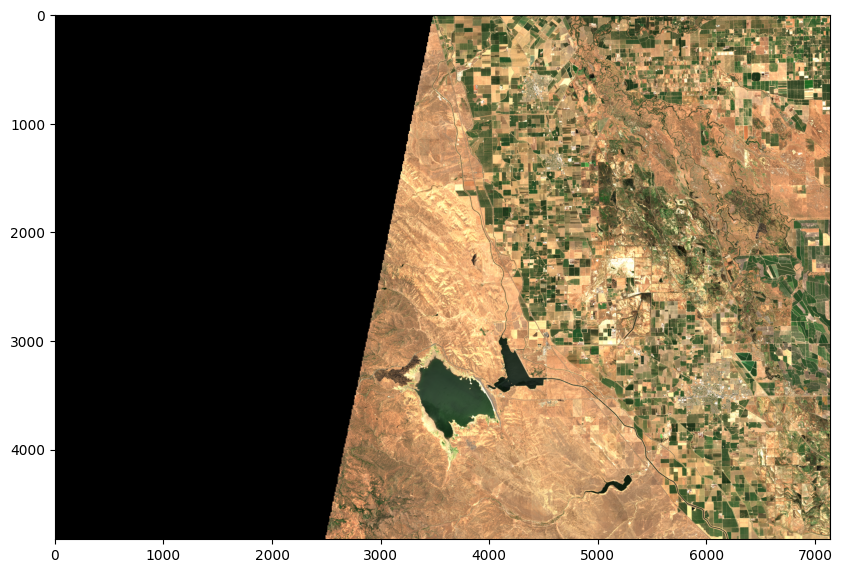

In [141]:

plt.figure(figsize=(10,10))
plt.imshow(np.transpose(zoomed_img_array, axes=[1, 2, 0]))

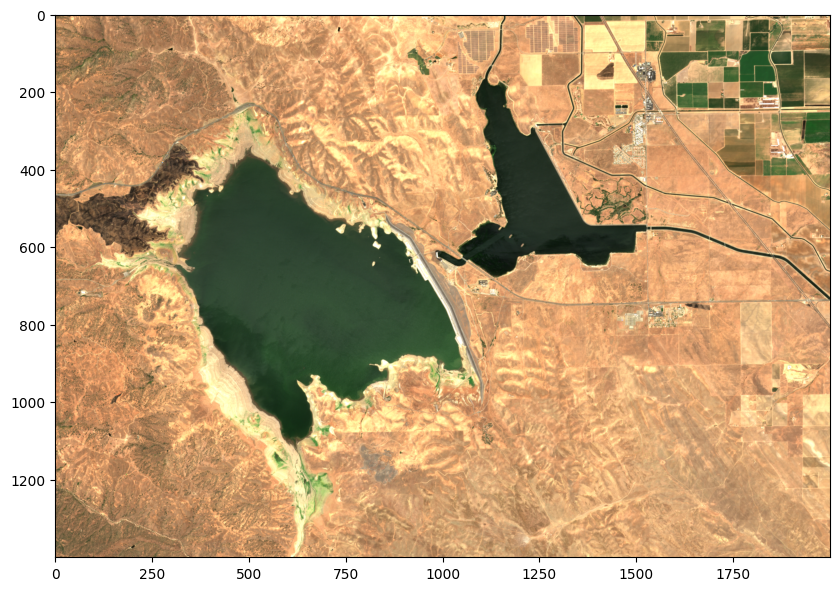

In [142]:
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(zoomed_img_array[:,2800:4200, 3000:5000], axes=[1, 2, 0]))

In [143]:
from PIL import Image

zoomed_img_array_reshaped = zoomed_img_array[:,2800:4200, 3000:5000].transpose(1, 2, 0).astype('uint8')

img = Image.fromarray(zoomed_img_array_reshaped) # Convert to PIL Image
img.save('/content/drive/MyDrive/DrivenData/images/zoomed_img_4.jpg')